<a href="https://colab.research.google.com/github/cadyngo/EAS-Math-for-AI/blob/main/08_Bayesian_Inference_and_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Bayesian Inference (Gaussian), Latent Variable Models, and Linear Regression (MLE vs MAP)

This notebook illustrates the main ideas from the Bayesian inference and linear regression slides,
using only **Gaussian distributions** (normal distributions) and mixtures of Gaussians:

* Probabilistic models and Bayesian inference (Gaussian mean with Gaussian prior)
* Latent-variable models and Gaussian mixtures
* Maximum Likelihood Estimation (MLE)
* Maximum A Posteriori Estimation (MAP)
* Linear regression, overfitting, and regularization

Each section has short explanations and executable code examples.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# for reproducibility
np.random.seed(42)



## 1. Bayesian Inference for a Gaussian Mean (Normal–Normal Model)

We consider data generated from a Gaussian (normal) distribution with **unknown mean** \\(\\mu\\)
and **known variance** \\(\\sigma^2\\):

$$
x_i \mid \mu \sim {N}(\mu, \sigma^2), \quad i = 1, \dots, N.
$$

We place a **Gaussian prior** on the unknown mean $\mu$:

$$
\mu \sim {N}(m_0, s_0^2).
$$

Given data \\(X = (x_1, \dots, x_N)\\), the posterior for \\(\mu\\) is also Gaussian
(conjugate prior):

$$
\mu \mid X \sim {N}(m_N, s_N^2),
$$

with


$s_N^2$ = $\left(\frac{1}{s_0^2} + \frac{N}{\sigma^2} \right)^{-1},
\qquad
m_N = s_N^2 \left( \frac{m_0}{s_0^2} + \frac{\sum_{i=1}^N x_i}{\sigma^2} \right)$.


Below we:

1. Simulate Gaussian data with unknown mean.
2. Compute the prior, likelihood (up to a constant), and posterior on a grid of \\(\mu\\).
3. Plot them to visualize Bayes' rule in action.


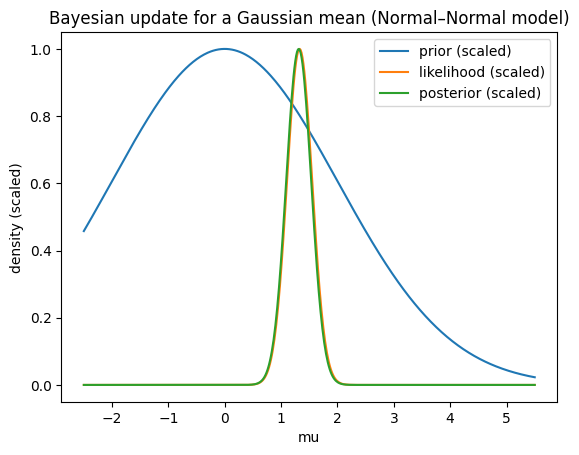

Number of points: 20
Sample mean of data: 1.329
Posterior mean m_N: 1.312, posterior std s_N: 0.222


In [ ]:

def gaussian_likelihood_grid(mu_grid, data, sigma):
    """Compute likelihood p(data | mu) on a grid (up to a constant factor)."""
    data = np.asarray(data)
    like_vals = np.ones_like(mu_grid)
    for x in data:
        like_vals *= norm.pdf(mu_grid, loc=x, scale=sigma)
    return like_vals

# Simulate data
true_mu = 1.5
sigma = 1.0
N = 20
data = np.random.normal(true_mu, sigma, size=N)

# Prior parameters
m0, s0 = 0.0, 2.0

# Posterior parameters (analytic)
sN2 = 1.0 / (1.0 / s0**2 + N / sigma**2)
mN = sN2 * (m0 / s0**2 + data.sum() / sigma**2)
sN = np.sqrt(sN2)

mu_grid = np.linspace(true_mu - 4.0, true_mu + 4.0, 500)

prior_vals = norm.pdf(mu_grid, loc=m0, scale=s0)
lik_vals = gaussian_likelihood_grid(mu_grid, data, sigma)
posterior_vals = norm.pdf(mu_grid, loc=mN, scale=sN)

plt.figure()
plt.plot(mu_grid, prior_vals / prior_vals.max(), label="prior (scaled)")
plt.plot(mu_grid, lik_vals / lik_vals.max(), label="likelihood (scaled)")
plt.plot(mu_grid, posterior_vals / posterior_vals.max(), label="posterior (scaled)")
plt.xlabel("mu")
plt.ylabel("density (scaled)")
plt.legend()
plt.title("Bayesian update for a Gaussian mean (Normal–Normal model)")
plt.show()

print(f"Number of points: {N}")
print(f"Sample mean of data: {data.mean():.3f}")
print(f"Posterior mean m_N: {mN:.3f}, posterior std s_N: {sN:.3f}")



### Posterior Predictive for a New Observation

Instead of plugging in a single estimate of \\(\mu\\), Bayesian prediction averages
over all plausible values of \\(\mu\\) under the posterior.

For the Normal–Normal model, the **posterior predictive distribution** for a new point
\\(x_{\\text{new}}\\) is also Gaussian:

$$
x_{\text{new}} \mid X \sim {N}(m_N,\; \sigma^2 + s_N^2).
$$

In particular,

$$
\mathbb{E}[x_{\text{new}} \mid X] = m_N.
$$

We compare this analytic result with Monte Carlo sampling.


In [ ]:

# Analytic posterior predictive mean
pred_mean_analytic = mN

# Monte Carlo approximation: sample mu from posterior, then x_new from N(mu, sigma^2)
num_samples = 50_000
mu_samples = np.random.normal(mN, sN, size=num_samples)
x_new_samples = np.random.normal(mu_samples, sigma, size=num_samples)
pred_mean_mc = x_new_samples.mean()

print(f"Analytic E[x_new | data] = {pred_mean_analytic:.4f}")
print(f"Monte Carlo estimate     = {pred_mean_mc:.4f}")


Analytic E[x_new | data] = 1.3123
Monte Carlo estimate     = 1.3143



## 2. Latent Variable Models: A Simple Gaussian Mixture

A classic example of a **latent-variable model** is a mixture of Gaussians.

Let $z \in \{1, \dots, K\}$ be a latent cluster indicator with prior

$$
p(z = k) = \pi_k.
$$

Conditional on $z$, the observation is

$$
x \mid z = k \sim {N}(\mu_k, \sigma_k^2).
$$

The **marginal likelihood** (with latent $z$ integrated out) is

$$
p(x \mid \theta) = \sum_{k=1}^K \pi_k \, {N}(x \mid \mu_k, \sigma_k^2).
$$

We will:

1. Sample data from a 1D mixture model.  
2. Visualize the components and the marginal mixture density.  
3. Compute the posterior over $z$ for a given $x$, i.e. $p(z \mid x, \theta)$.


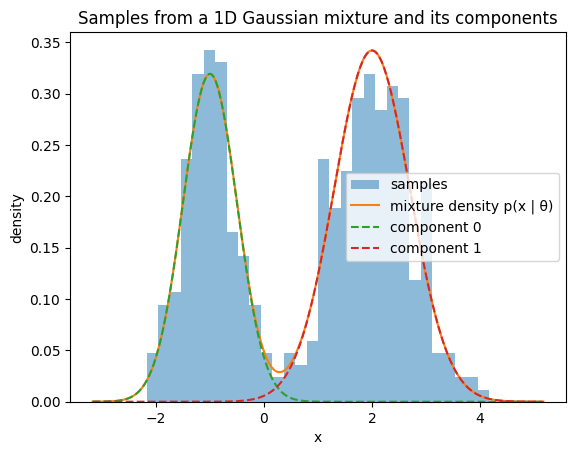

In [ ]:

# Define a simple 1D Gaussian mixture with K=2
pis = np.array([0.4, 0.6])
mus = np.array([-1.0, 2.0])
sigmas = np.array([0.5, 0.7])

def sample_gmm(num_samples=300):
    z = np.random.choice(len(pis), size=num_samples, p=pis)
    x = np.random.normal(mus[z], sigmas[z])
    return x, z

def gmm_pdf(x):
    x = np.asarray(x)
    total = np.zeros_like(x, dtype=float)
    for pi_k, mu_k, sigma_k in zip(pis, mus, sigmas):
        total += pi_k * norm.pdf(x, mu_k, sigma_k)
    return total

# Sample and visualize
x_samples, z_samples = sample_gmm(400)

plt.figure()
plt.hist(x_samples, bins=30, density=True, alpha=0.5, label="samples")
grid = np.linspace(x_samples.min() - 1.0, x_samples.max() + 1.0, 400)
plt.plot(grid, gmm_pdf(grid), label="mixture density p(x | θ)")
for k in range(len(pis)):
    plt.plot(grid, pis[k] * norm.pdf(grid, mus[k], sigmas[k]), linestyle="--",
             label=f"component {k}")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.title("Samples from a 1D Gaussian mixture and its components")
plt.show()



### Posterior over the Latent Variable

For fixed parameters \\(\theta = (\pi, \mu, \sigma)\\), Bayes' rule gives

$$
p(z = k \mid x, \theta)
  \propto p(x \mid z = k, \theta) \, p(z = k)
  = \pi_k \, {N}(x \mid \mu_k, \sigma_k^2).
$$

We can compute this posterior for each data point.


In [ ]:

def posterior_z_given_x(x):
    """Return posterior p(z | x, θ) for each x (shape: [len(x), K])."""
    x = np.asarray(x)
    K = len(pis)
    numerators = np.zeros((len(x), K))
    for k in range(K):
        numerators[:, k] = pis[k] * norm.pdf(x, mus[k], sigmas[k])
    denominators = numerators.sum(axis=1, keepdims=True)
    return numerators / denominators

# Show responsibilities for a few points
x_test = np.linspace(-2.0, 3.5, 8)
post_z = posterior_z_given_x(x_test)

for xi, probs in zip(x_test, post_z):
    print(f"x = {xi:5.2f}  ->  p(z | x) = {probs}")


x = -2.00  ->  p(z | x) = [9.99999357e-01 6.42731751e-07]
x = -1.21  ->  p(z | x) = [9.99969005e-01 3.09950300e-05]
x = -0.43  ->  p(z | x) = [0.99501474 0.00498526]
x =  0.36  ->  p(z | x) = [0.26921568 0.73078432]
x =  1.14  ->  p(z | x) = [2.02822052e-04 9.99797178e-01]
x =  1.93  ->  p(z | x) = [3.33286661e-08 9.99999967e-01]
x =  2.71  ->  p(z | x) = [1.63363553e-12 1.00000000e+00]
x =  3.50  ->  p(z | x) = [2.38899333e-17 1.00000000e+00]



## 3. Linear Regression with Gaussian Noise

We use a standard linear regression model with Gaussian noise:

$$
y = \phi(x)^\top \theta + \varepsilon, \qquad \varepsilon \sim {N}(0, \sigma^2).
$$

With i.i.d. data $(x_i, y_i)$ and design matrix $\Phi$, the **negative log-likelihood**
(up to constants) is

$$
L(\theta) = \frac{1}{2\sigma^2} \lVert y - \Phi \theta \rVert_2^2.
$$

The MLE solution is the least-squares estimator:

$$
\theta_{\text{ML}} = (\Phi^\top \Phi)^{-1} \Phi^\top y.
$$

Below we:

1. Generate synthetic data from a smooth function plus noise.  
2. Fit polynomial regression models with MLE.  
3. Visualize overfitting for high-degree polynomials.


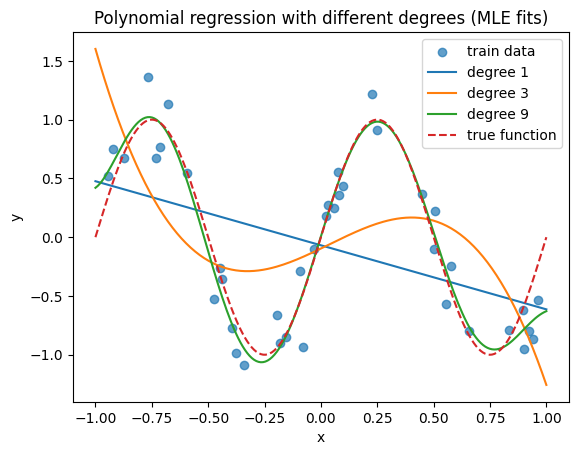

In [ ]:

def make_regression_data(N=40, noise_std=0.3, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.uniform(-1.0, 1.0, size=N)
    # underlying smooth function
    y_true = np.sin(2 * np.pi * x)
    y = y_true + rng.normal(0.0, noise_std, size=N)
    return np.sort(x), y[np.argsort(x)], y_true[np.argsort(x)]

def polynomial_features(x, degree):
    x = np.asarray(x)
    Phi = np.vstack([x**k for k in range(degree + 1)]).T
    return Phi

# Create train/test splits
x_train, y_train, y_true_train = make_regression_data(N=40, noise_std=0.3, seed=1)
x_test, y_test, y_true_test = make_regression_data(N=200, noise_std=0.0, seed=2)

def fit_mle_poly(degree):
    Phi_train = polynomial_features(x_train, degree)
    theta_ml = np.linalg.pinv(Phi_train) @ y_train
    return theta_ml

def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))

degrees_list = [1, 3, 9]

plt.figure()
plt.scatter(x_train, y_train, label="train data", alpha=0.7)

x_plot = np.linspace(-1, 1, 200)

for d in degrees_list:
    theta_ml = fit_mle_poly(d)
    Phi_plot = polynomial_features(x_plot, d)
    y_plot = Phi_plot @ theta_ml
    plt.plot(x_plot, y_plot, label=f"degree {d}")

plt.plot(x_plot, np.sin(2 * np.pi * x_plot), linestyle="--", label="true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Polynomial regression with different degrees (MLE fits)")
plt.show()



### Training vs Test Error and Overfitting

We now quantify training and test error (RMSE) as a function of the polynomial degree.

High degrees typically **drive training error down** but can **increase test error**, a sign of overfitting.


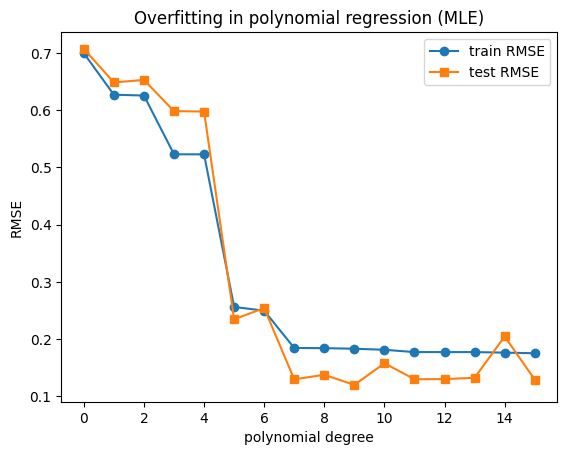

In [ ]:

max_degree = 15
train_errors = []
test_errors = []

for d in range(0, max_degree + 1):
    Phi_train = polynomial_features(x_train, d)
    theta_ml = np.linalg.pinv(Phi_train) @ y_train

    Phi_train_pred = Phi_train
    Phi_test_pred = polynomial_features(x_test, d)

    y_train_pred = Phi_train_pred @ theta_ml
    y_test_pred = Phi_test_pred @ theta_ml

    train_errors.append(rmse(y_train, y_train_pred))
    test_errors.append(rmse(y_test, y_test_pred))

degrees_arr = np.arange(0, max_degree + 1)

plt.figure()
plt.plot(degrees_arr, train_errors, marker="o", label="train RMSE")
plt.plot(degrees_arr, test_errors, marker="s", label="test RMSE")
plt.xlabel("polynomial degree")
plt.ylabel("RMSE")
plt.legend()
plt.title("Overfitting in polynomial regression (MLE)")
plt.show()



## 4. MAP Estimation and L2 Regularization (Ridge)

Placing a Gaussian prior on the parameter vector $\theta$,

$$
\theta \sim \mathcal{N}(0, b^2 I),
$$

and combining it with the Gaussian likelihood gives a posterior whose **mode** (MAP)
is the solution of a **regularized least-squares problem**:

$$
\theta_{\text{MAP}}
= \arg\min_{\theta}
\left[
\frac{1}{2\sigma^2} \lVert y - \Phi \theta \rVert_2^2
+ \frac{1}{2b^2} \lVert \theta \rVert_2^2
\right].
$$

If we define $\lambda = \sigma^2 / b^2$, the closed-form solution is

$$
\theta_{\text{MAP}}
= (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top y,
$$

which is exactly **ridge regression**.


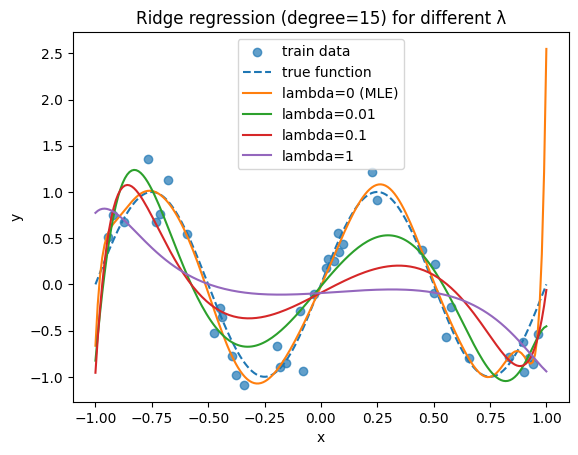

In [ ]:

def fit_ridge_poly(degree, lam):
    Phi_train = polynomial_features(x_train, degree)
    I = np.eye(Phi_train.shape[1])
    theta_map = np.linalg.solve(Phi_train.T @ Phi_train + lam * I,
                                Phi_train.T @ y_train)
    return theta_map

degree_reg = 15  # deliberately high to show regularization effect
lambdas = [0.0, 1e-2, 1e-1, 1.0]

plt.figure()
plt.scatter(x_train, y_train, label="train data", alpha=0.7)
x_plot = np.linspace(-1, 1, 200)
plt.plot(x_plot, np.sin(2 * np.pi * x_plot), linestyle="--", label="true function")

for lam in lambdas:
    if lam == 0.0:
        theta = fit_mle_poly(degree_reg)
        label = "lambda=0 (MLE)"
    else:
        theta = fit_ridge_poly(degree_reg, lam)
        label = f"lambda={lam:g}"
    y_plot = polynomial_features(x_plot, degree_reg) @ theta
    plt.plot(x_plot, y_plot, label=label)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title(f"Ridge regression (degree={degree_reg}) for different λ")
plt.show()



### Effect of Regularization Strength on Coefficients

Larger $\lambda$ values shrink the parameter vector $\theta$ toward zero.
We can visualize the $\ell_2$-norm of $\theta_{\text{MAP}}$ as a function of $\lambda$.


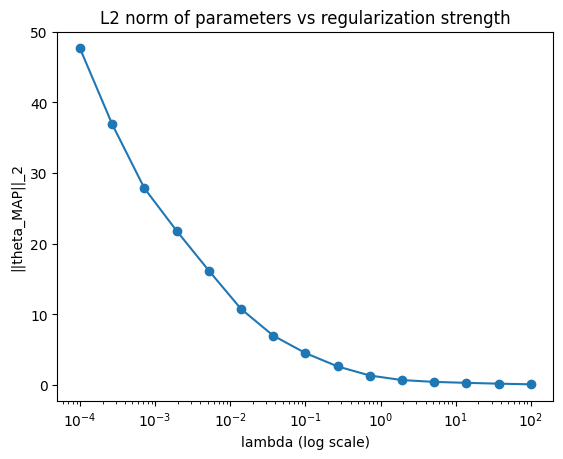

In [ ]:

degree_reg = 15
lambda_grid = np.logspace(-4, 2, 15)
theta_norms = []

for lam in lambda_grid:
    theta = fit_ridge_poly(degree_reg, lam)
    theta_norms.append(np.linalg.norm(theta, 2))

plt.figure()
plt.semilogx(lambda_grid, theta_norms, marker="o")
plt.xlabel("lambda (log scale)")
plt.ylabel("||theta_MAP||_2")
plt.title("L2 norm of parameters vs regularization strength")
plt.show()



# Exercises
These cells are designed as short “fill in 1–2 lines” checks of understanding.  
For each exercise, complete the lines marked **TODO**, then run the cell. Each cell includes simple assertions for self-checking.



## Exercise 1 — Normal–Normal Posterior (Gaussian mean inference)

Assume:

$$
x_i \mid \mu \sim {N}(\mu, \sigma^2), \quad \mu \sim {N}(m_0, s_0^2).
$$

The posterior is:

$$
\mu \mid X \sim {N}(m_N, s_N^2),
\quad
s_N^2 = \left(\frac{1}{s_0^2} + \frac{N}{\sigma^2}\right)^{-1},
\quad
m_N = s_N^2\left(\frac{m_0}{s_0^2} + \frac{\sum_i x_i}{\sigma^2}\right).
$$

**Task:** Fill in the two TODO lines to compute `sN2` and `mN`.


In [ ]:

import numpy as np

np.random.seed(0)

# Data: unknown mean mu, known sigma
true_mu = 1.5
sigma = 1.0
N = 10
x = np.random.normal(true_mu, sigma, size=N)

# Prior: mu ~ N(m0, s0^2)
m0, s0 = 0.0, 2.0

# TODO (1): compute posterior variance sN2
sN2 = None  # replace None

# TODO (2): compute posterior mean mN
mN = None   # replace None

print("sample mean:", x.mean())
print("posterior mean mN:", mN)
print("posterior std sN:", np.sqrt(sN2))

# Sanity checks (should pass once TODOs are filled)
assert sN2 > 0
assert abs(mN - x.mean()) < 0.5



## Exercise 2 — MAP for Linear Regression = Ridge Regression

For linear regression with Gaussian noise, if we place a Gaussian prior on parameters:

$$
\theta \sim {N}(0, b^2 I),
$$

then the MAP estimate solves ridge regression:

$$
\theta_{\text{MAP}} = (\Phi^\top \Phi + \lambda I)^{-1}\Phi^\top y.
$$

**Task:** Fill in the TODO line to compute the ridge/MAP estimate `theta`.


In [ ]:

import numpy as np

def polynomial_features(x, degree):
    x = np.asarray(x)
    return np.vstack([x**k for k in range(degree + 1)]).T

np.random.seed(1)

# Synthetic regression data
N = 30
x = np.linspace(-1, 1, N)
y = np.sin(2 * np.pi * x) + np.random.normal(0, 0.3, size=N)

degree = 9
Phi = polynomial_features(x, degree)
lam = 0.1

# TODO: ridge / MAP closed-form solution
# theta = (Phi^T Phi + lam I)^{-1} Phi^T y
theta = None  # replace None

y_hat = Phi @ theta
rmse = np.sqrt(np.mean((y - y_hat)**2))

print("train RMSE:", rmse)

# Sanity checks (should pass once TODO is filled)
assert np.isfinite(rmse)
assert rmse < 1.0



## Exercise 3 — Posterior over a Latent Variable (GMM responsibilities)

For a Gaussian mixture model with parameters $(\pi_k, \mu_k, \sigma_k)$, the posterior over the latent component is:

$$
p(z=k \mid x) \propto \pi_k \, {N}(x \mid \mu_k, \sigma_k^2).
$$

**Task:** Fill in the two TODO lines to compute the responsibilities `resp` and verify that each row sums to 1.


In [ ]:

import numpy as np
from scipy.stats import norm

# Mixture parameters (K=2)
pis = np.array([0.4, 0.6])
mus = np.array([-1.0, 2.0])
sigmas = np.array([0.5, 0.7])

# Points to classify
x = np.array([-1.5, -0.2, 0.5, 2.2])

K = len(pis)
numerators = np.zeros((len(x), K))

# TODO (1): fill numerators[:, k] = pi_k * N(x | mu_k, sigma_k^2) for each k
# (Write 1–2 lines total; a short for-loop is fine.)

# TODO (2): normalize numerators across k to get responsibilities
resp = None  # replace None

print("resp =\n", resp)
print("row sums:", resp.sum(axis=1))

# Sanity checks (should pass once TODOs are filled)
assert np.allclose(resp.sum(axis=1), 1.0)
assert np.all(resp >= 0)



## 5. Summary

In this notebook we:

* Used **Bayesian inference** to update beliefs about the mean of a Gaussian (normal) distribution
  using a Gaussian prior and derived the Normal–Normal posterior.
* Illustrated a simple **latent-variable model** (Gaussian mixture), including marginalization
  over the latent variable and the posterior over latent assignments.
* Derived and implemented **MLE** for linear regression and showed how high model complexity
  leads to **overfitting**.
* Showed that adding a Gaussian prior on parameters leads to **MAP estimation**, which is
  equivalent to **ridge regression** with an \\(\\ell_2\\) penalty.

You can now adapt these code snippets to your own datasets or extend them to higher-dimensional problems.
